In [1]:
from algo_reasoning.src.models.network import EncodeProcessDecode
from algo_reasoning.src.data import CLRSDataset, CLRSSampler, collate
from torch.utils.data import DataLoader
from algo_reasoning.src.data import CLRSData

import numpy as np
import pandas as pd


import torch
import torch.nn as nn
import torch.nn.functional as F

2024-09-10 10:23:32.418659: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-10 10:23:32.441899: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-10 10:23:32.441947: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-10 10:23:33.360001: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/ronald/Documents/env/algo_reasoning/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autono

# Three Kinds Dice

## Load Dataset and Models

In [2]:
algos = [
    'articulation_points',
    'activity_selector',
    'bellman_ford',
    'bfs',
    'binary_search',
    'bubble_sort',
    'dag_shortest_paths',
    'dfs',
    'dijkstra',
    'find_maximum_subarray_kadane',
    'floyd_warshall',
    'graham_scan',
    'heapsort',
    'insertion_sort',
    'jarvis_march',
    'kmp_matcher',
    'matrix_chain_order',
    'minimum',
    'mst_kruskal',
    'mst_prim',
    'naive_string_matcher',
    'optimal_bst',
    'quickselect',
    'quicksort',
    'segments_intersect',
    'strongly_connected_components',
    'task_scheduling',
    'topological_sort',
]

In [3]:
algorithms = ["three_kinds_dice"]
three_kinds_dice_ds = CLRSDataset(algorithms, "train", "tmp/CLRS30")

algorithms2 = ["jarvis_march"]
jarvis_march_ds = CLRSDataset(algorithms2, "train", "tmp/CLRS30")

In [4]:
processor = EncodeProcessDecode(algos).to(torch.device("cuda")).processor
state_dict = torch.load("checkpoints/Generalist_GMPNN_WithoutTeacherForcing/Generalist_GMPNN_WithoutTeacherForcing-epoch=95-val_loss=0.39.ckpt", map_location=torch.device("cuda"))["state_dict"]
new_state_dict = {}
for key in state_dict:
    if "processor" in key:
        new_state_dict[key.replace("model.processor.", "")] = state_dict[key]

processor.load_state_dict(new_state_dict)

generalist_model = EncodeProcessDecode(algos, pretrained_processor=processor).to(torch.device("cuda"))

pretrained_state_dict = torch.load("checkpoints/ThreeKindsDice_Pretrained/ThreeKindsDice_Pretrained-epoch=92-val_loss=0.02.ckpt", map_location=torch.device("cuda"))["state_dict"]
state_dict = torch.load("checkpoints/ThreeKindsDice_NotPretrained/ThreeKindsDice_NotPretrained-epoch=89-val_loss=0.02.ckpt", map_location=torch.device("cuda"))["state_dict"]

new_state_dict = {}
new_pretrained_state_dict = {}
for key in state_dict:
    if "model" in key:
        new_state_dict[key.replace("model.", "")] = state_dict[key]
        new_pretrained_state_dict[key.replace("model.", "")] = pretrained_state_dict[key]
pretrained_three_kinds_dice_model = EncodeProcessDecode(algorithms).to(torch.device("cuda"))
three_kinds_dice_model = EncodeProcessDecode(algorithms).to(torch.device("cuda"))
pretrained_three_kinds_dice_model.load_state_dict(new_pretrained_state_dict)
three_kinds_dice_model.load_state_dict(new_state_dict)

/tmp/ipykernel_18596/544470129.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("checkpoints/Generalist_GMPNN_WithoutTeacherForcing/Generalist_GMP

<All keys matched successfully>

## Calculate model's vector embeddings

In [5]:
hidden_embedding_three_kinds_dice = []
hidden_embedding_pretrained_three_kinds_dice = []

hidden_embedding_generalist = []

with torch.no_grad():
    for i in range(len(three_kinds_dice_ds)):
        sample = three_kinds_dice_ds[i]
        output, hidden_embeddings = three_kinds_dice_model(sample.to(torch.device("cuda")))
        hidden_embedding_three_kinds_dice.append(hidden_embeddings)

        output, pretrained_hidden_embeddings = pretrained_three_kinds_dice_model(sample.to(torch.device("cuda")))
        hidden_embedding_pretrained_three_kinds_dice.append(pretrained_hidden_embeddings)
    
        jarvis_march_input = CLRSData(inputs=CLRSData(pos=sample.inputs.pos, x=sample.hints.score_D1[:, 0, :], y=sample.hints.score_D2[:, 0, :]), 
                                      hints=CLRSData(), 
                                      length=torch.tensor(50).float(), 
                                      max_length=torch.tensor(50).float(),
                                      outputs=CLRSData(), 
                                      algorithm="jarvis_march")
        
        output_jarvis_march, hidden_embeddings_jarvis_march = generalist_model(jarvis_march_input.to(torch.device("cuda")))
        hidden_embedding_generalist.append(hidden_embeddings_jarvis_march)

/home/ronald/Documents/algo_reasoning/algo_reasoning/src/data.py:199: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f"{self.data_folder}/{algorithm}/{self.

## Calculate Embedding's Similarities

In [15]:
def calculate_embedding_similarities(embedding, embedding_generalist):
    embedding_similarities = []

    for i in range(len(three_kinds_dice_ds)):
        embedding_similarities.append([])
        embedding1 = embedding[i].detach().cpu()
        embedding2 = embedding_generalist[i].detach().cpu()
    
        for j in range(embedding1.shape[0]):
            for k in range(embedding2.shape[0]):
                embedding_similarities[i].append(F.cosine_similarity(embedding1[j], embedding2[k]).mean().item())

    sim_df = pd.DataFrame(embedding_similarities)

    return sim_df

In [16]:
pretrained_sim_df = calculate_embedding_similarities(hidden_embedding_pretrained_three_kinds_dice, hidden_embedding_generalist)
sim_df = calculate_embedding_similarities(hidden_embedding_three_kinds_dice, hidden_embedding_generalist)

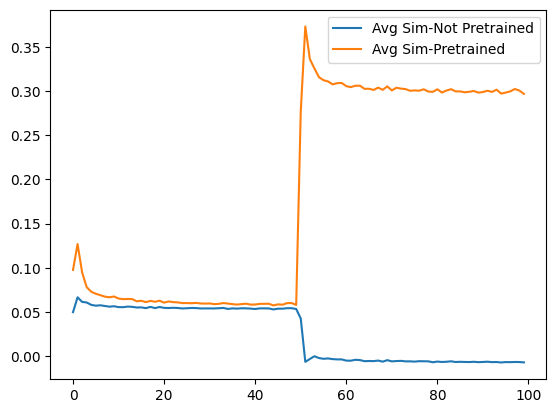

In [24]:
import matplotlib.pyplot as plt

plt.plot(sim_df.mean(), label="Avg Sim-Not Pretrained")
plt.plot(pretrained_sim_df.mean(), label="Avg Sim-Pretrained")
plt.legend()
plt.show()

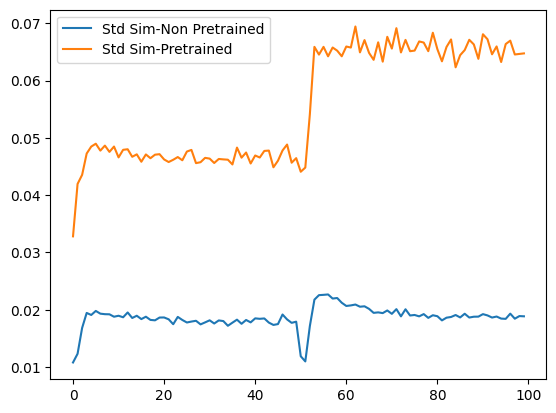

In [25]:
import matplotlib.pyplot as plt

plt.plot(sim_df.std(), label="Std Sim-Non Pretrained")
plt.plot(pretrained_sim_df.std(), label="Std Sim-Pretrained")
plt.legend()

# Carl's Vacation

# Load Dataset and Models

In [26]:
algorithms = ["carls_vacation"]
carls_vacation_ds = CLRSDataset(algorithms, "train", "tmp/CLRS30")

algorithms2 = ["segments_intersect"]
segments_intersect_ds = CLRSDataset(algorithms2, "train", "tmp/CLRS30")

In [40]:
segments_intersect_ds[0].inputs.x

tensor([[0.9953, 0.5485, 0.9985, 0.0862]])

In [28]:
pretrained_state_dict = torch.load("checkpoints/CarlsVacation_Pretrained/CarlsVacation_Pretrained-epoch=98-val_loss=776.55.ckpt", map_location=torch.device("cuda"))["state_dict"]
state_dict = torch.load("checkpoints/CarlsVacation_NotPretrained/CarlsVacation_NotPretrained-epoch=66-val_loss=708.88.ckpt", map_location=torch.device("cuda"))["state_dict"]

new_state_dict = {}
new_pretrained_state_dict = {}
for key in state_dict:
    if "model" in key:
        new_state_dict[key.replace("model.", "")] = state_dict[key]
        new_pretrained_state_dict[key.replace("model.", "")] = pretrained_state_dict[key]
pretrained_carls_vacation_model = EncodeProcessDecode(algorithms).to(torch.device("cuda"))
carls_vacation_model = EncodeProcessDecode(algorithms).to(torch.device("cuda"))
pretrained_carls_vacation_model.load_state_dict(new_pretrained_state_dict)
carls_vacation_model.load_state_dict(new_state_dict)

/tmp/ipykernel_18596/2522272692.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_state_dict = torch.load("checkpoints/CarlsVacation_Pretrained/CarlsVacation_Pr

<All keys matched successfully>

In [33]:
carls_vacation_ds[0].hints

CLRSData(faces1_x=[1, 2, 4], faces1_y=[1, 3, 4], faces2_x=[1, 2, 4], faces2_y=[1, 2, 4], selected_segment1=[1, 2, 4], selected_segment2=[1, 2, 4])

In [37]:
carls_vacation_ds[0].hints.selected_segment2

tensor([[[0., 0., 0., 0.],
         [1., 0., 0., 1.]]])

In [ ]:
hidden_embedding_three_kinds_dice = []
hidden_embedding_pretrained_three_kinds_dice = []

hidden_embedding_generalist = []

with torch.no_grad():
    for i in range(len(three_kinds_dice_ds)):
        sample = three_kinds_dice_ds[i]
        output, hidden_embeddings = carls_vacation_model(sample.to(torch.device("cuda")))
        hidden_embedding_three_kinds_dice.append(hidden_embeddings)

        output, pretrained_hidden_embeddings = pretrained_carls_vacation_model(sample.to(torch.device("cuda")))
        hidden_embedding_pretrained_three_kinds_dice.append(pretrained_hidden_embeddings)
    
        jarvis_march_input = CLRSData(inputs=CLRSData(pos=sample.inputs.pos, x=sample.hints.score_D1[:, 0, :], y=sample.hints.score_D2[:, 0, :]), 
                                      hints=CLRSData(), 
                                      length=torch.tensor(50).float(), 
                                      max_length=torch.tensor(50).float(),
                                      outputs=CLRSData(), 
                                      algorithm="jarvis_march")
        
        output_jarvis_march, hidden_embeddings_jarvis_march = generalist_model(jarvis_march_input.to(torch.device("cuda")))
        hidden_embedding_generalist.append(hidden_embeddings_jarvis_march)